In [1]:
import os
import neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the dataframes

In [3]:
date_str = 'May01_2pm'
fig_sav_loc = '/Users/jonaheaton/Desktop/fig_save_{}'.format(date_str)
os.makedirs(fig_sav_loc, exist_ok=True)

In [10]:



file1 = '/Users/jonaheaton/Desktop/VAE April26 part1.csv'
file2 = '/Users/jonaheaton/Desktop/VAE April26 part2.csv'
# file3 = '/Users/jonaheaton/Desktop/VAE April26 part3.csv'

df2 = pd.read_csv(file2, index_col=0)
df1 = pd.read_csv(file1, index_col=0)
# df3 = pd.read_csv(file3, index_col=0)
df = df1.join(df2, how='outer', lsuffix='_1', rsuffix='_2')
# df = df.join(df3, how='outer', rsuffix='_3')



In [11]:
# get the important tages
from collections import defaultdict
important_tags = ['april17_best90','april17_pareto','april15_leila','april18_top200','april18_best20','april18_leila']
runs_with_tags_dict= defaultdict(list)

if 'Tags' not in df.columns:
    df['Tags'] = '[]'
if 'Tags_1' not in df.columns:
    df['Tags_1'] = '[]'
if 'Tags_2' not in df.columns:
    df['Tags_2'] = '[]'

for tag in important_tags:
    for run_id in df.index:
        tags_in_run = eval(df.loc[run_id]['Tags'])+eval(df.loc[run_id]['Tags_2'])+eval(df.loc[run_id]['Tags_1'])
        if tag in tags_in_run:
            runs_with_tags_dict[tag].append(run_id)

## Cleanup and Simplify the dataframe to the essential bits

In [12]:
pretrain_objectives = ['Reconstruction Loss (val)',' StudyID AUC (val)', 'CohortLabel AUC (val)','Gender AUC (val)','AgeGroup AUC (val)', 'Age MAE (val)']


finetune_objectives = ['MSKCC AUC (finetune, val)', 'MSKCC AUC (finetune, train)', 'MSKCC AUC (randinit, val)',\
                       'IMDC AUC (finetune, val)', 'IMDC AUC (finetune, train)', 'IMDC AUC (randinit, val)']

key_params = ['Latent dim', '# hidden layers','']#, 'Learning Rate', 'Num Epochs']


search_dct = {
    ####### Pretrain Val
    'Reconstruction Loss (val)': {
        'must_contain_all': ['recon','/val'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'StudyID AUC (val)': {
        'must_contain_all': ['StudyID','AUROC','/val'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'CohortLabel AUC (val)': {
        'must_contain_all': ['AUROC','/val'],
        'must_contain_one': ['CohortLabel','Cohort Label'],
        'exact_matches': []
    },
    'Gender AUC (val)': {
        'must_contain_all': ['AUROC','/val'],
        'must_contain_one': ['isFemale','Gender'],
        'exact_matches': []
    },
    'AgeGroup AUC (val)': {
        'must_contain_all': ['AUROC','/val','isPediatric'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'Age MAE (val)': {
        'must_contain_all': ['MAE','/val'],
        'must_contain_one': ['Age'],
        'exact_matches': []
    },

    ####### Pretrain Test
    'Reconstruction Loss (test)': {
        'must_contain_all': ['recon','test'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'StudyID AUC (test)': {
        'must_contain_all': ['StudyID','AUROC','test'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'CohortLabel AUC (test)': {
        'must_contain_all': ['AUROC','test'],
        'must_contain_one': ['CohortLabel','Cohort Label'],
        'exact_matches': []
    },
    'Gender AUC (test)': {
        'must_contain_all': ['AUROC','test'],
        'must_contain_one': ['isFemale','Gender'],
        'exact_matches': []
    },
    'AgeGroup AUC (test)': {
        'must_contain_all': ['AUROC','test','isPediatric'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'Age MAE (test)': {
        'must_contain_all': ['MAE','test'],
        'must_contain_one': ['Age'],
        'exact_matches': []
    },

    ####### MSKCC Finetune
    'MSKCC AUC (finetune, val)': {
        'must_contain_all': ['MSKCC','finetune','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'MSKCC AUC (finetune, train)': {
        'must_contain_all': ['MSKCC','finetune','train'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['variance','std'],
        'exact_matches': []
    },
    'MSKCC AUC (randinit, val)': {
        'must_contain_all': ['MSKCC','randinit','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'IMDC AUC (finetune, val)': {
        'must_contain_all': ['IMDC','finetune','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ####### IMDC Finetune
    'IMDC AUC (finetune, train)': {
        'must_contain_all': ['IMDC','finetune','train'],
        'must_contain_one': ['AUROC','AUC'],
        'exact_matches': [],
        'must_not_contain': ['variance','std'],
    },
    'IMDC AUC (randinit, val)': {
        'must_contain_all': ['IMDC','randinit','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ###### Model Params
    'Latent dim': {
        'must_contain_all': ['latent'],
        'must_contain_one': [],
        'exact_matches': []
    },
    '# hidden layers': {
        'must_contain_all': ['layers'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'encoder kind':{
        'must_contain_all': ['encoder','kind'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'study name':{
        'must_contain_all': ['original_kwargs','study_info_dict','study_name'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'learning rate':{
        'must_contain_all': ['original_kwargs','pretrain'],
        'must_contain_one': ['lr','learning rate'],
        'exact_matches': []
    },

    ##### Both OS
    'Both OS C-Index (finetune, val)': {
        'must_contain_all': ['both-OS','finetune','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'Both OS C-Index (finetune, train)': {
        'must_contain_all': ['both-OS','finetune','train','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std'],
        'exact_matches': []
    },
    'Both OS C-Index (randinit, val)': {
        'must_contain_all': ['both-OS','randinit','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ##### Both PFS
    'Both PFS C-Index (finetune, val)': {
        'must_contain_all': ['both-PFS','finetune','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','OS'],
        'exact_matches': []
    },
    'Both PFS C-Index (finetune, train)': {
        'must_contain_all': ['both-PFS','finetune','train','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std','OS'],
        'exact_matches': []
    },
    'Both PFS C-Index (randinit, val)': {
        'must_contain_all': ['both-PFS','randinit','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','OS'],
        'exact_matches': []
    },

    ##### NIVO OS
    'NIVO OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS','finetune','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','EVER','ever','PFS'],
        'exact_matches': []
    },
    'NIVO OS C-Index (finetune, train)': {
        'must_contain_all': ['NIVO-OS','finetune','train','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std','EVER','ever','PFS'],
        'exact_matches': []
    },
    'NIVO OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS','randinit','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','EVER','ever','PFS'],
        'exact_matches': []
    },

    ##### NIVO OS from multi-OS
    'multi(N+E OS) NIVO OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','finetune','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','hhl','PFS'],
        'exact_matches': []
    },
    'multi(N+E OS) NIVO OS C-Index (finetune, train)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','finetune','train','Concordance','Cox_NIVO OS'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std','hhl','PFS'],
        'exact_matches': []
    },
    'multi(N+E OS) NIVO OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','randinit','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','hhl','PFS'],
        'exact_matches': []
    },

    ##### EVER OS
    'EVER OS C-Index (finetune, val)': {
        'must_contain_all': ['EVER-OS','finetune','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','NIVO','nivo','PFS'],
        'exact_matches': []
    },
    'EVER OS C-Index (finetune, train)': {
        'must_contain_all': ['EVER-OS','finetune','train','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std','NIVO','nivo','PFS'],
        'exact_matches': []
    },
    'EVER OS C-Index (randinit, val)': {
        'must_contain_all': ['EVER-OS','randinit','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','NIVO','nivo','PFS'],
        'exact_matches': []
    },

    ##### EVER OS from multi-OS
    'multi(N+E OS) EVER OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','finetune','val','Concordance','Cox_EVER OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','hhl'],
        'exact_matches': []
    },
    'multi(N+E OS) EVER OS C-Index (finetune, train)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','finetune','train','Concordance','Cox_EVER OS'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std','hhl'],
        'exact_matches': []
    },
    'multi(N+E OS) EVER OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','randinit','val','Concordance','Cox_EVER OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','hhl'],
        'exact_matches': []
    },

    ##### NIVO OS from multi-OS hhl
    'multi(N+E OS, hhl) NIVO OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','finetune','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl epc_60','hhl'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    'multi(N+E OS, hhl) NIVO OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','randinit','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl epc_60','hhl'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ##### EVER OS from multi-OS hhl
    'multi(N+E OS, hhl) EVER OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','finetune','val','Concordance','Cox_EVER OS'],
        'must_contain_one': ['hhl epc_60','hhl'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    'multi(N+E OS, hhl) EVER OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS AND EVER-OS','randinit','val','Concordance','Cox_EVER OS'],
        'must_contain_one': ['hhl epc_60','hhl'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ##### NIVO OS from multi-NIVO OS+PFS hhl
    'multi(N OS+PFS, hhl) NIVO OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS AND NIVO-PFS','finetune','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    'multi(N OS+PFS, hhl) NIVO OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS AND NIVO-PFS','randinit','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ##### NIVO PFS from multi-NIVO OS+PFS hhl
    'multi(N OS+PFS, hhl) NIVO PFS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS AND NIVO-PFS','finetune','val','Concordance','Cox_NIVO PFS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    'multi(N OS+PFS, hhl) NIVO PFS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS AND NIVO-PFS','randinit','val','Concordance','Cox_NIVO PFS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ##### NIVO PFS from multi-PFS
    'multi(N+E PFS) NIVO PFS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-PFS AND EVER-PFS','finetune','val','Concordance','Cox_NIVO PFS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    'multi(N+E PFS) NIVO PFS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-PFS AND EVER-PFS','randinit','val','Concordance','Cox_NIVO PFS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ##### EVER PFS from multi-PFS
    'multi(N+E PFS) EVER PFS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-PFS AND EVER-PFS','finetune','val','Concordance','Cox_EVER PFS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    'multi(N+E PFS) EVER PFS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-PFS AND EVER-PFS','randinit','val','Concordance','Cox_EVER PFS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    ##### NIVO PFS from multi-PFS+OS, hhl, NIVO weight 5
    'multi(N+E OS+PFS, hhl, w5 on N) NIVO PFS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','finetune','val','Concordance','Cox_NIVO PFS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    'multi(N+E OS+PFS, hhl, w5 on N) NIVO PFS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','randinit','val','Concordance','Cox_NIVO PFS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    ##### EVER PFS from multi-PFS+OS, hhl, NIVO weight 5
    'multi(N+E OS+PFS, hhl, w5 on N) EVER PFS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','finetune','val','Concordance','Cox_EVER PFS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    'multi(N+E OS+PFS, hhl, w5 on N) EVER PFS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','randinit','val','Concordance','Cox_EVER PFS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    ##### NIVO OS from multi-PFS+OS, hhl, NIVO weight 5
    'multi(N+E OS+PFS, hhl, w5 on N) NIVO OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','finetune','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    'multi(N+E OS+PFS, hhl, w5 on N) NIVO OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','randinit','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    ##### EVER OS from multi-PFS+OS, hhl, EVER weight 5
    'multi(N+E OS+PFS, hhl, w5 on N) EVER OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','finetune','val','Concordance','Cox_EVER OS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    'multi(N+E OS+PFS, hhl, w5 on N) EVER OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS weight-5 AND NIVO-PFS weight-5 AND EVER-PFS AND EVER-OS','randinit','val','Concordance','Cox_EVER OS'],
        'must_contain_one': ['hhl'],
        'must_not_contain': ['train','variance','std'],
    },

    ##### NIVO OS from multi-OS hhl, NIVO weight 2
    'multi(N+E OS, hhl, w2 on N) NIVO OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS weight-2 AND EVER-OS','finetune','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
    },

    'multi(N+E OS, hhl, w2 on N) NIVO OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS weight-2 AND EVER-OS','randinit','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
    },

    ##### EVER OS from multi-OS hhl, NIVO weight 2
    'multi(N+E OS, hhl, w2 on N) EVER OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS weight-2 AND EVER-OS','finetune','val','Concordance','Cox_EVER OS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
    },

    'multi(N+E OS, hhl, w2 on N) EVER OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS weight-2 AND EVER-OS','randinit','val','Concordance','Cox_EVER OS'],
        'must_contain_one': ['hhl','hhl epc_60'],
        'must_not_contain': ['train','variance','std'],
    },


    ##### NIVO OS from adversarial-OS
    'adv(N+E OS) NIVO OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS ADV EVER-OS','finetune','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','val2_EVER OS'],
        'exact_matches': []
    },

    'adv(N+E OS) NIVO OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS ADV EVER-OS','randinit','val','Concordance','Cox_NIVO OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std','val2_EVER OS'],
        'exact_matches': []
    },

    ##### EVER OS from adversarial-OS
    'adv(N+E OS) EVER OS C-Index (finetune, val)': {
        'must_contain_all': ['NIVO-OS ADV EVER-OS','finetune','val2_EVER OS','Concordance','Cox_NIVO OS'],
        # 'must_contain_all': ['NIVO-OS ADV EVER-OS','finetune','val','Concordance','Cox_EVER OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

    'adv(N+E OS) EVER OS C-Index (randinit, val)': {
        'must_contain_all': ['NIVO-OS ADV EVER-OS','randinit','val2_EVER OS','Concordance','Cox_NIVO OS'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },

}




In [13]:
# find the matches to the search dictionary for each important objective/parameter

input_cols = df.columns
selected_cols = []

for obj in search_dct.keys():

    print(obj)
    for col in df.columns:
        
        # first check of the column is already selected for an objective
        if col in selected_cols:
            continue

        if 'exact_matches' not in search_dct[obj]:
            search_dct[obj]['exact_matches'] = []

        # then check for exact matches
        if col in search_dct[obj]['exact_matches']:
            # print(obj, col)
            selected_cols.append(col)

        # then check if the column contains all of the must_contain_all words
        elif len(search_dct[obj]['must_contain_all'])==0 or all([x.lower() in col.lower() for x in search_dct[obj]['must_contain_all']]):
            if len(search_dct[obj]['must_contain_one'])==0 or any([x.lower() in col.lower() for x in search_dct[obj]['must_contain_one']]):
                if len(search_dct[obj].get('must_not_contain', []))==0 or all([x.lower() not in col.lower() for x in search_dct[obj].get('must_not_contain', [])]):

                    # print(obj, col)
                    selected_cols.append(col)
            
                    search_dct[obj]['exact_matches'].append(col)
            

Reconstruction Loss (val)
StudyID AUC (val)
CohortLabel AUC (val)
Gender AUC (val)
AgeGroup AUC (val)
Age MAE (val)
Reconstruction Loss (test)
StudyID AUC (test)
CohortLabel AUC (test)
Gender AUC (test)
AgeGroup AUC (test)
Age MAE (test)
MSKCC AUC (finetune, val)
MSKCC AUC (finetune, train)
MSKCC AUC (randinit, val)
IMDC AUC (finetune, val)
IMDC AUC (finetune, train)
IMDC AUC (randinit, val)
Latent dim
# hidden layers
encoder kind
study name
learning rate
Both OS C-Index (finetune, val)
Both OS C-Index (finetune, train)
Both OS C-Index (randinit, val)
Both PFS C-Index (finetune, val)
Both PFS C-Index (finetune, train)
Both PFS C-Index (randinit, val)
NIVO OS C-Index (finetune, val)
NIVO OS C-Index (finetune, train)
NIVO OS C-Index (randinit, val)
multi(N+E OS) NIVO OS C-Index (finetune, val)
multi(N+E OS) NIVO OS C-Index (finetune, train)
multi(N+E OS) NIVO OS C-Index (randinit, val)
EVER OS C-Index (finetune, val)
EVER OS C-Index (finetune, train)
EVER OS C-Index (randinit, val)
multi

In [14]:
search_dct['multi(N OS+PFS, hhl) NIVO OS C-Index (finetune, val)']

{'must_contain_all': ['NIVO-OS AND NIVO-PFS',
  'finetune',
  'val',
  'Concordance',
  'Cox_NIVO OS'],
 'must_contain_one': ['hhl', 'hhl epc_60'],
 'must_not_contain': ['train', 'variance', 'std'],
 'exact_matches': ['NIVO-OS AND NIVO-PFS hhl_finetune/eval/val2/Cox_NIVO OS__Concordance Index (average)']}

In [15]:
# use the search_dct to create a new dataframe from the selected columns

df = df[selected_cols].copy()

for obj in search_dct.keys():
    if len(search_dct[obj]['exact_matches'])==0:
        print(obj, 'not found')
        continue

    if len(search_dct[obj]['exact_matches'])==1:
        # rename the column to the objective name
        df = df.rename(columns={search_dct[obj]['exact_matches'][0]: obj})
    
    else:
        print(obj, 'multiple matches', search_dct[obj]['exact_matches'])
        # merge the columns into a single column
        # if the columns are numeric then take the mean
        if all(df[search_dct[obj]['exact_matches']].dtypes != 'object'):
            df[obj] = df[search_dct[obj]['exact_matches']].mean(axis=1) # ignore nan
            
        else:
            # if the columns are not numeric then take the first one
            df[obj] = df[search_dct[obj]['exact_matches'][0]]
        df = df.drop(columns=search_dct[obj]['exact_matches'])
        


MSKCC AUC (finetune, val) multiple matches ['MSKCC_finetune/eval/val/Binary_MSKCC__AUROC (micro) (average)', 'MSKCC_finetune/eval/val2/Binary_MSKCC__AUROC (micro) (average)']
MSKCC AUC (finetune, train) multiple matches ['MSKCC_finetune/eval/train/Binary_MSKCC__AUROC (micro) (average)', 'MSKCC_finetune/eval/train2/Binary_MSKCC__AUROC (micro) (average)']
MSKCC AUC (randinit, val) multiple matches ['MSKCC_randinit/eval/val/Binary_MSKCC__AUROC (micro) (average)', 'MSKCC_randinit/eval/val2/Binary_MSKCC__AUROC (micro) (average)']
IMDC AUC (finetune, val) multiple matches ['IMDC_finetune/eval/val/Binary_IMDC__AUROC (micro) (average)', 'IMDC_finetune/eval/val2/Binary_IMDC__AUROC (micro) (average)']
IMDC AUC (finetune, train) multiple matches ['IMDC_finetune/eval/train/Binary_IMDC__AUROC (micro) (average)', 'IMDC_finetune/eval/train2/Binary_IMDC__AUROC (micro) (average)']
IMDC AUC (randinit, val) multiple matches ['IMDC_randinit/eval/val/Binary_IMDC__AUROC (micro) (average)', 'IMDC_randinit/ev

In [16]:
df

,Reconstruction Loss (val),StudyID AUC (val),CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),Age MAE (val),Reconstruction Loss (test),StudyID AUC (test),CohortLabel AUC (test),Gender AUC (test),...,"IMDC AUC (finetune, train)","IMDC AUC (randinit, val)","multi(N+E OS, hhl) NIVO OS C-Index (finetune, val)","multi(N+E OS, hhl) NIVO OS C-Index (randinit, val)","multi(N+E OS, hhl) EVER OS C-Index (finetune, val)","multi(N+E OS, hhl) EVER OS C-Index (randinit, val)","adv(N+E OS) NIVO OS C-Index (finetune, val)","adv(N+E OS) NIVO OS C-Index (randinit, val)","adv(N+E OS) EVER OS C-Index (finetune, val)","adv(N+E OS) EVER OS C-Index (randinit, val)"
Id,,,,,,,,,,,,,,,,,,,,,
RCC-3028,0.603903,0.839010,0.935471,0.840494,0.985297,10.237596,0.566387,0.852077,0.941353,0.837099,...,0.999916,0.876224,0.647883,0.520637,0.649687,0.520527,0.488862,0.519201,0.465955,0.497911
RCC-3023,0.534138,0.899557,0.994522,0.864898,0.997601,9.889881,0.514851,0.901446,0.995300,0.870557,...,0.985592,0.500000,0.577053,0.500000,0.579529,0.500000,0.513338,0.494155,0.524449,0.492700
RCC-3021,0.476244,0.925489,0.992976,0.857330,0.995996,10.146655,0.467415,0.911472,0.992259,0.846023,...,0.998568,0.891958,0.651105,0.647957,0.652062,0.647202,0.490887,0.477080,0.488200,0.461341
RCC-3018,0.518505,0.912619,0.993210,0.873936,0.996396,9.675152,0.501337,0.920208,0.993403,0.860353,...,0.995484,0.894988,0.624190,0.596852,0.623932,0.599116,0.480099,0.514323,0.468308,0.511180
RCC-3011,0.473475,0.920653,0.994112,0.873616,0.998267,9.324108,0.465599,0.910608,0.993483,0.867086,...,0.968891,0.500000,0.595269,0.500000,0.607585,0.500000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-2165,0.532357,0.883376,0.973548,0.869820,0.993358,10.172802,0.513401,0.886675,0.973616,0.878704,...,0.999930,0.859207,0.650515,0.500000,0.650018,0.500000,0.494551,0.570563,0.481107,0.557461
RCC-2164,0.533183,0.842629,0.960989,0.855671,0.992749,10.979807,0.515403,0.854875,0.958635,0.862427,...,0.999947,0.891239,0.660236,0.650828,0.657309,0.650571,0.512776,0.565022,0.505234,0.519421
RCC-2159,0.540912,0.888345,0.980206,0.857083,0.993985,9.945249,0.520774,0.889993,0.978831,0.871794,...,0.999582,0.859771,0.618814,0.506259,0.619919,0.506259,0.517949,0.577485,0.502020,0.566024


In [17]:
df['model complexity'] = df['Latent dim']*df['# hidden layers']
# df['MSKCC AUC Diff (fine-rand)'] = df['MSKCC AUC (finetune, val)'] - df['MSKCC AUC (randinit, val)']
# df['IMDC AUC Diff (fine-rand)'] = df['IMDC AUC (finetune, val)'] - df['IMDC AUC (randinit, val)']
# df['Both OS C-Index Diff (fine-rand)'] = df['Both OS C-Index (finetune, val)'] - df['Both OS C-Index (randinit, val)']
# df['Both PFS C-Index Diff (fine-rand)'] = df['Both PFS C-Index (finetune, val)'] - df['Both PFS C-Index (randinit, val)']

In [18]:
finetune_cols = [col for col in df.columns if 'finetune' in col]
# remove cols with "train"
finetune_cols = [col for col in finetune_cols if 'train' not in col]
corresponding_randinit_cols = [col.replace('finetune','randinit') for col in finetune_cols]
for f_col, r_col in zip(finetune_cols, corresponding_randinit_cols):
    df[f_col.replace('finetune','PvsR Diff')] = df[f_col] - df[r_col]



In [19]:
# add the import tags
for tag in important_tags:
    df['Has Tag '+tag] = df.index.isin(runs_with_tags_dict[tag])

In [20]:
df.dropna(subset=['Gender AUC (val)','Age MAE (val)'], inplace=True)

# drop outliers in the Age MAE
df = df[df['Age MAE (val)']<100].copy()


## Now that it is clean we can do analysis

In [21]:
# pretrain_objectives = ['Reconstruction Loss (val)','StudyID AUC (val)', 'CohortLabel AUC (val)','Gender AUC (val)','AgeGroup AUC (val)', 'Age MAE (val)']


# finetune_objectives = ['MSKCC AUC (finetune, val)', 'MSKCC AUC (randinit, val)',\
#                        'IMDC AUC (finetune, val)', 'IMDC AUC (randinit, val)',\
#                         'Both OS C-Index (finetune, val)', 'Both OS C-Index (randinit, val)',
#                         'Both PFS C-Index (finetune, val)', 'Both PFS C-Index (randinit, val)',
#                         'NIVO OS C-Index (finetune, val)', 'NIVO OS C-Index (randinit, val)',
#                         'EVER OS C-Index (finetune, val)', 'EVER OS C-Index (randinit, val)',
#                         'multitask NIVO OS C-Index (finetune, val)', 'multitask NIVO OS C-Index (randinit, val)',
#                         'multitask EVER OS C-Index (finetune, val)', 'multitask EVER OS C-Index (randinit, val)']

# key_params = ['Latent dim', '# hidden layers','model complexity']#, 'Learning Rate', 'Num Epochs']

# key_cols = pretrain_objectives+finetune_objectives+key_params

In [22]:
df['study name'].value_counts()

study name
Multi Obj Apr11v2    60
Multi Obj Apr12      32
Multi Obj Apr15      29
Multi Obj Apr10       2
Name: count, dtype: int64

In [23]:
df['encoder kind'].value_counts()

encoder kind
VAE    123
Name: count, dtype: int64

In [24]:
ae_models = df[df['encoder kind']=='AE'].copy()
vae_models = df[df['encoder kind']=='VAE'].copy()


In [25]:

# ae_models.sort_values('Age MAE (val)',ascending=True, inplace=True)
# ae_models.sort_values('Gender AUC (val)', inplace=True, ascending=False)
# ae_models.to_csv(f'/Users/jonaheaton/Desktop/ae_models {date_str}.csv')


vae_models.sort_values('Age MAE (val)',ascending=True, inplace=True)
vae_models.sort_values('Gender AUC (val)', inplace=True, ascending=False)
vae_models.to_csv(f'/Users/jonaheaton/Desktop/vae_models {date_str}.csv')

In [26]:
def update_directions_and_scales(df):

    df['neg log Reconstruction Loss (val)'] = -1* np.log(df['Reconstruction Loss (val)'])
    # remove the old column
    df = df.drop(columns=['Reconstruction Loss (val)'])

    df['neg Age MAE'] = -1*df['Age MAE (val)']
    df['neg Age MSE'] = -1*df['Age MAE (val)']
    df['neg StudyID AUC (val)'] = -1*df['StudyID AUC (val)']
    df.drop(columns=['Age MAE (val)','Age MAE (val)','StudyID AUC (val)'], inplace=True)


    df.drop(columns=['MSKCC AUC (finetune, train)', 'IMDC AUC (finetune, train)','neg Age MSE'], inplace=True)
    # drop any columns that have "train"
    df.drop(columns=[col for col in df.columns if 'train' in col],inplace=True)
    # drop the columns about tags
    df.drop(columns=[col for col in df.columns if 'Has Tag' in col], inplace=True)
    # drop any non-numeric columns
    df = df.select_dtypes(include=[np.number]).copy()

    

    return df

In [27]:
vae_model_clean = update_directions_and_scales(vae_models.copy())

In [28]:
vae_model_clean

,CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),Reconstruction Loss (test),StudyID AUC (test),CohortLabel AUC (test),Gender AUC (test),AgeGroup AUC (test),Age MAE (test),Latent dim,...,"multi(N+E OS, hhl, w2 on N) EVER OS C-Index (PvsR Diff, val)","MSKCC AUC (PvsR Diff, val)","IMDC AUC (PvsR Diff, val)","multi(N+E OS, hhl) NIVO OS C-Index (PvsR Diff, val)","multi(N+E OS, hhl) EVER OS C-Index (PvsR Diff, val)","adv(N+E OS) NIVO OS C-Index (PvsR Diff, val)","adv(N+E OS) EVER OS C-Index (PvsR Diff, val)",neg log Reconstruction Loss (val),neg Age MAE,neg StudyID AUC (val)
Id,,,,,,,,,,,,,,,,,,,,,
RCC-2987,0.989760,0.887873,0.995976,0.491452,0.501630,0.988833,0.875791,0.996797,9.144186,119,...,0.149779,0.366071,0.413986,0.115427,0.116357,0.001022,0.008551,0.676420,-9.704203,-0.504746
RCC-2507,0.979680,0.886695,0.995847,0.609133,0.879472,0.977799,0.881178,0.996001,7.987088,29,...,-0.048417,0.068100,0.032440,0.035512,0.036561,-0.050405,0.027617,0.450439,-8.908306,-0.881439
RCC-2390,0.994176,0.883874,0.998718,0.520810,0.913662,0.995404,0.868491,0.998926,8.264792,43,...,-0.040943,0.211982,0.093920,0.035309,0.047772,-0.007511,0.018021,0.612910,-8.784323,-0.911842
RCC-2370,0.976300,0.882854,0.996565,0.509915,0.847067,0.977445,0.878796,0.997306,9.702105,45,...,NaN,0.330732,0.056876,0.120232,0.120619,-0.015114,-0.004270,0.634367,-10.472920,-0.839552
RCC-2876,0.936456,0.882306,0.992389,0.588277,0.846730,0.932689,0.870766,0.992763,9.264757,29,...,0.006370,0.086100,0.022145,0.084278,0.082180,0.008155,0.012477,0.487039,-9.479546,-0.844738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-2338,0.971979,0.829564,0.976104,0.509744,0.875780,0.970504,0.805672,0.982378,8.785818,30,...,0.043041,0.183951,0.016900,0.094146,0.094726,-0.097791,-0.062856,0.642752,-9.782214,-0.870409
RCC-2246,0.912051,0.829005,0.986304,0.549190,0.824414,0.919700,0.828357,0.989923,9.840161,45,...,0.065722,0.305919,0.161189,0.117066,0.121383,-0.039194,-0.032277,0.558248,-9.906956,-0.815406
RCC-2185,0.922460,0.828800,0.990250,0.551600,0.828469,0.921815,0.816732,0.992660,9.990180,34,...,0.012003,0.000077,0.017249,-0.023435,-0.025589,-0.109573,-0.104270,0.565740,-10.260836,-0.820591


In [22]:
# create plots comparing the finetune results between finetune and randinit
if False: 
    os.makedirs(fig_sav_loc,exist_ok=True)

    finetune_cols = [col for col in df.columns if 'finetune' in col]
    # remove cols with "train"
    finetune_cols = [col for col in finetune_cols if 'train' not in col]
    corresponding_randinit_cols = [col.replace('finetune','randinit') for col in finetune_cols]
    corresponding_diff_cols = [col.replace('finetune','PvsR Diff') for col in finetune_cols]

    for f_col, r_col, d_col in zip(finetune_cols, corresponding_randinit_cols, corresponding_diff_cols):
        
        sup_name = f_col.replace('finetune, ','')
        save_name = sup_name.replace('(','').replace(')','')

        x_max = round(max(max(df[f_col].max(),df[r_col].max())+0.02,0.7),2)

        fig, axs = plt.subplots(3, 1, figsize=(8,8))
        # create vertical spacing between suplots
        plt.subplots_adjust(hspace=0.5,top=0.95)
        temp= df[f_col].copy()
        temp[temp<0.5] = 0.5
        axs[0].hist(temp,bins=np.arange(0.5,x_max,0.01))
        axs[0].set_xlabel(f_col)

        temp= df[r_col].copy()
        temp[temp<0.5] = 0.5
        axs[1].hist(temp,bins=np.arange(0.5,x_max,0.01))
        axs[1].set_xlabel(r_col)

        temp = df[d_col].copy()
        temp[temp<-0.2] = 0.2
        temp[temp>0.2] = 0.2
        axs[2].hist(df[d_col],bins=np.arange(-0.2,0.22,0.01))
        axs[2].set_xlabel(d_col)

        fig.suptitle(sup_name)

        plt.savefig(os.path.join(fig_sav_loc,save_name),bbox_inches='tight')
        plt.close()

        # break


In [25]:
vae_model_clean
no_diff_cols = [col for col in vae_model_clean.columns if 'PvsR Diff' not in col]

only_single_task_cols = [col for col in no_diff_cols if 'multi' not in col]
only_single_task_cols = [col for col in only_single_task_cols if 'adv' not in col]

only_single_os_cols = [col for col in only_single_task_cols if 'PFS' not in col]

In [26]:
only_single_os_cols

['CohortLabel AUC (val)',
 'Gender AUC (val)',
 'AgeGroup AUC (val)',
 'Latent dim',
 '# hidden layers',
 'Both OS C-Index (finetune, val)',
 'Both OS C-Index (randinit, val)',
 'NIVO OS C-Index (finetune, val)',
 'NIVO OS C-Index (randinit, val)',
 'EVER OS C-Index (finetune, val)',
 'EVER OS C-Index (randinit, val)',
 'MSKCC AUC (finetune, val)',
 'MSKCC AUC (randinit, val)',
 'IMDC AUC (finetune, val)',
 'IMDC AUC (randinit, val)',
 'model complexity',
 'neg log Reconstruction Loss (val)',
 'neg Age MAE',
 'neg StudyID AUC (val)']

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'CohortLabel AUC (val)'),
  Text(1.5, 0, 'Gender AUC (val)'),
  Text(2.5, 0, 'AgeGroup AUC (val)'),
  Text(3.5, 0, 'Latent dim'),
  Text(4.5, 0, '# hidden layers'),
  Text(5.5, 0, 'Both OS C-Index (finetune, val)'),
  Text(6.5, 0, 'Both OS C-Index (randinit, val)'),
  Text(7.5, 0, 'NIVO OS C-Index (finetune, val)'),
  Text(8.5, 0, 'NIVO OS C-Index (randinit, val)'),
  Text(9.5, 0, 'EVER OS C-Index (finetune, val)'),
  Text(10.5, 0, 'EVER OS C-Index (randinit, val)'),
  Text(11.5, 0, 'MSKCC AUC (finetune, val)'),
  Text(12.5, 0, 'MSKCC AUC (randinit, val)'),
  Text(13.5, 0, 'IMDC AUC (finetune, val)'),
  Text(14.5, 0, 'IMDC AUC (randinit, val)'),
  Text(15.5, 0, 'model complexity'),
  Text(16.5, 0, 'neg log Reconstruction Loss (val)'),
  Text(17.5, 0, 'neg Age MAE'),
  Text(18.5, 0, 'neg StudyID AUC (val)')])

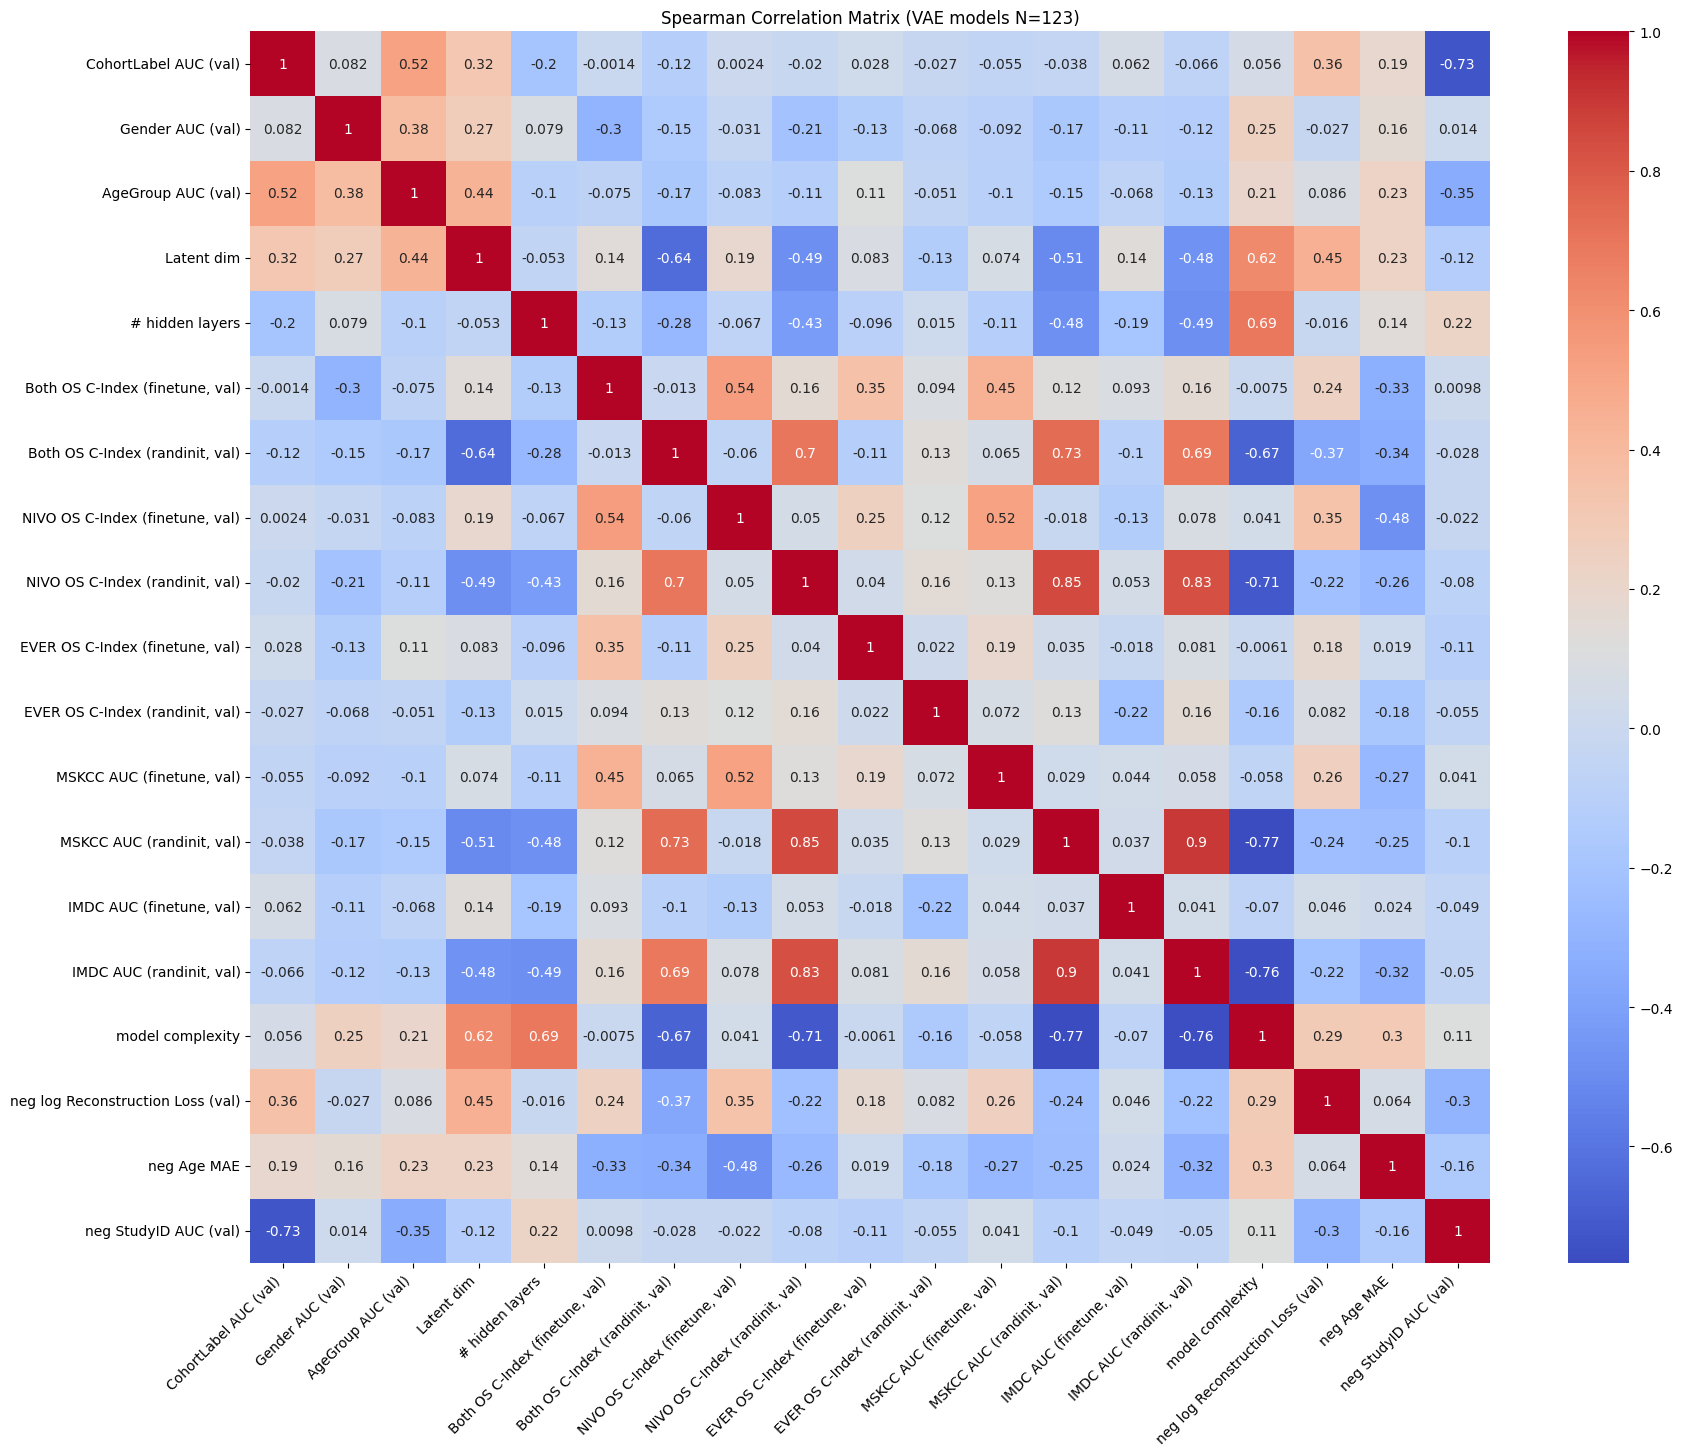

In [27]:
# Compute the correlation matrix

# corr_matrix = vae_model_clean[no_diff_cols].corr(method='spearman')
corr_matrix = vae_model_clean[only_single_os_cols].corr(method='spearman')
num_models = vae_model_clean.shape[0]
# Plot the correlation matrix
# make the plot bigger
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f'Spearman Correlation Matrix (VAE models N={num_models})')

# rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# plt.savefig(f'/Users/jonaheaton/Desktop/vae_correlation_matrix {date_str}.png')

In [28]:
nonan_corr_matrix = corr_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all')
nonan_corr_matrix = nonan_corr_matrix.dropna(axis=0).dropna(axis=1).round(2)
col_categ = pd.DataFrame(index=nonan_corr_matrix.index)
pretrain_cols = ['neg log Reconstruction Loss (val)','neg StudyID AUC (val)','CohortLabel AUC (val)','Gender AUC (val)'	,'AgeGroup AUC (val)','neg Age MAE']
structure_cols = ['Latent dim', '# hidden layers','model complexity']
finetune_cols = [col for col in col_categ.index if 'finetune' in col]
randinit_cols = [col for col in col_categ.index if 'randinit' in col]
diff_cols = [col for col in col_categ.index if 'PvsR Diff' in col]

col_categ['Category'] = None
col_categ.loc[pretrain_cols,'Category'] = 'Pretrain'
col_categ.loc[structure_cols,'Category'] = 'Structure'
col_categ.loc[finetune_cols,'Category'] = 'Finetune'
col_categ.loc[randinit_cols,'Category'] = 'Randinit'
col_categ.loc[diff_cols,'Category'] = 'PvsR Diff'
col_categ['Category'] = col_categ['Category'].fillna('Other')



# create a dictionary mapping the category to a color from a seaborn palette
num_categories = len(col_categ['Category'].unique())
colors = sns.color_palette('pastel', num_categories)
cat_color = dict(zip(col_categ['Category'].unique(), colors))

# convert the category to a color
row_colors = col_categ['Category'].map(cat_color)


In [30]:
nonan_corr_matrix.shape

(19, 19)

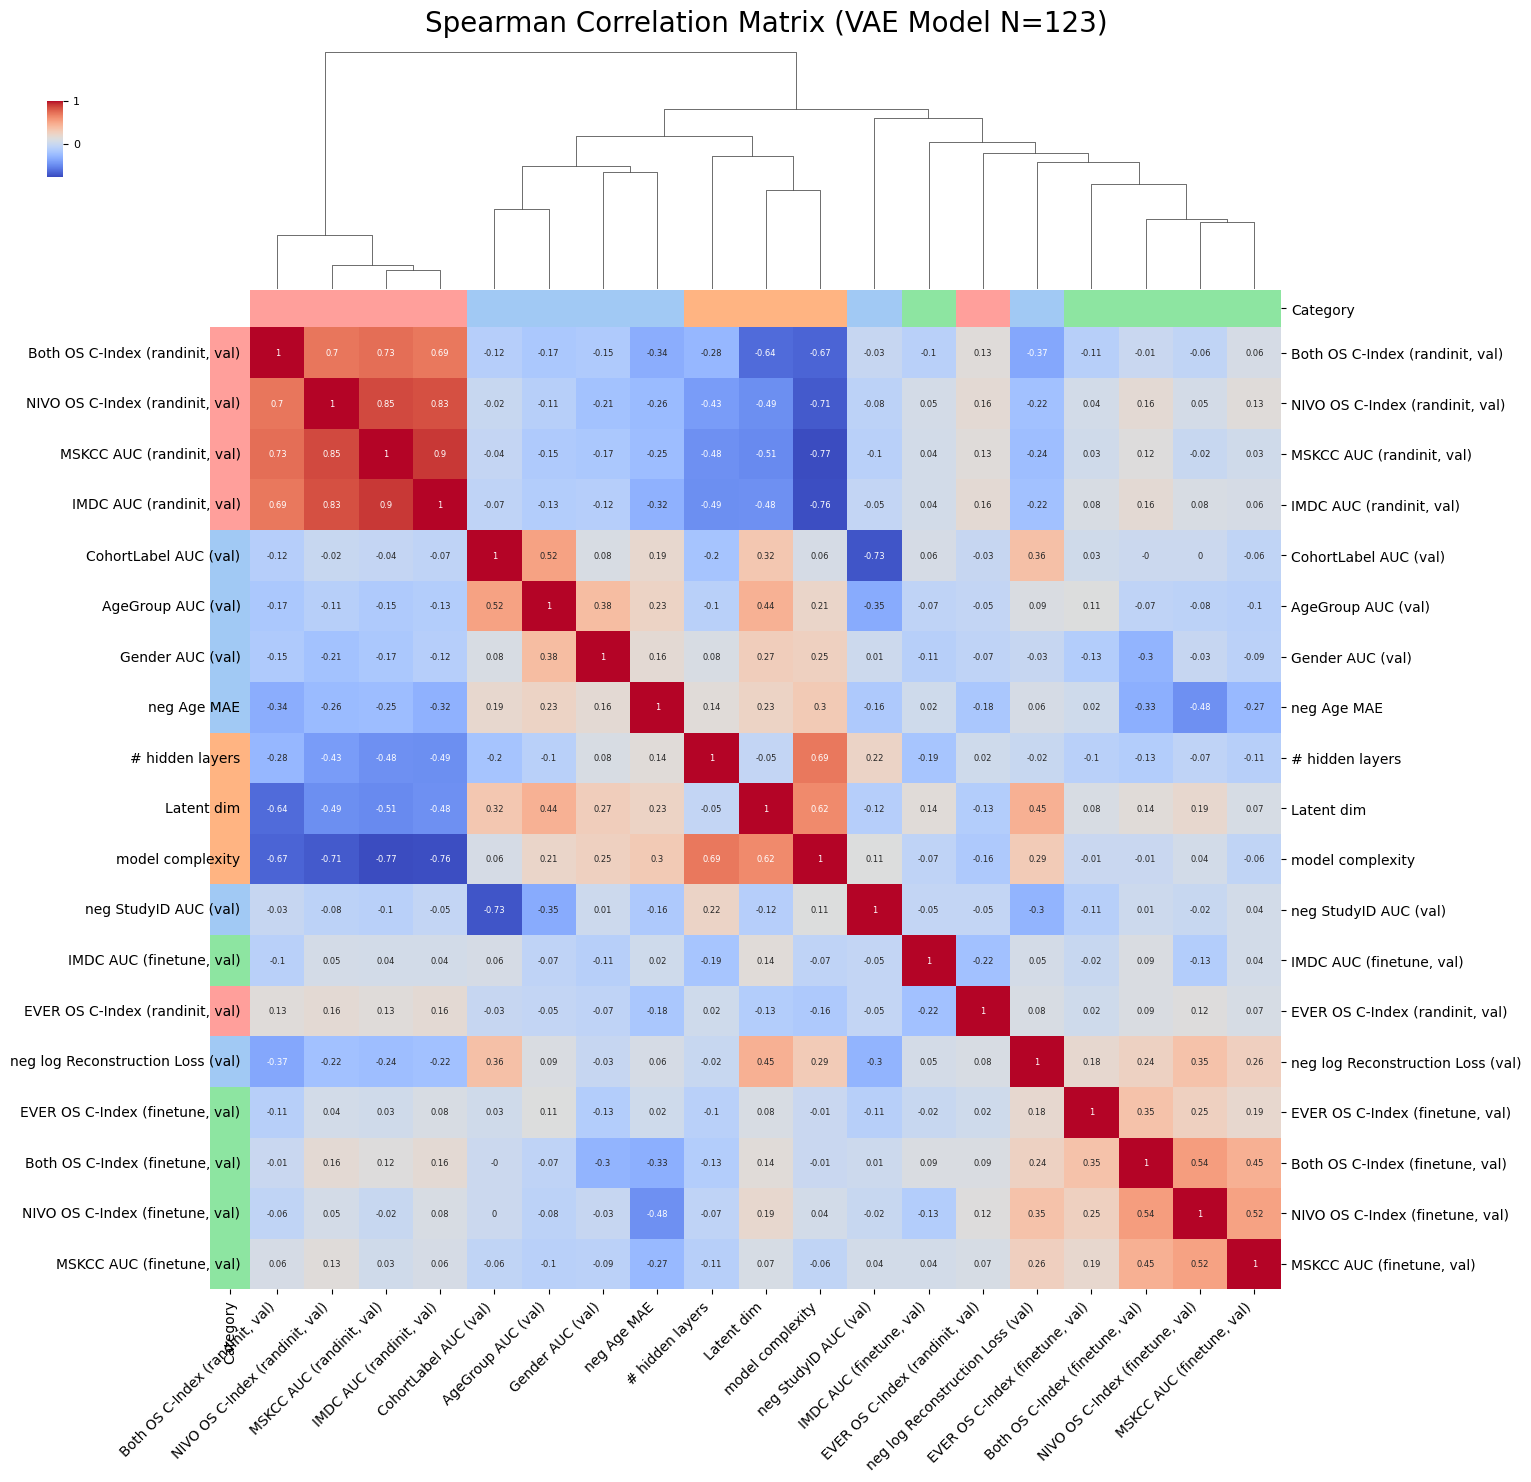

In [33]:
# sns.set_context('notebook')
nonan_corr_matrix = corr_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all')
nonan_corr_matrix = nonan_corr_matrix.dropna(axis=0).dropna(axis=1).round(2)

30, 

fig_height = round(nonan_corr_matrix.shape[0]*0.85,1) #30
fig_width = round(nonan_corr_matrix.shape[1]*0.80,1) #27

# plt.figure(figsize=(30, 27))
cax = sns.clustermap(nonan_corr_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 6},figsize=(fig_height, fig_width), 
                     cbar_kws={"shrink": 0.5},cbar_pos=(0.075,0.9,0.01,0.05),
                     row_colors=row_colors,
                    col_colors=row_colors
)

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# place ticks on the right and on the left
cax.ax_heatmap.tick_params(axis='y', which='both', labelright=True, labelleft=True)

# turn off the right side dendrogram
cax.ax_row_dendrogram.set_visible(False)

# Set axis label size
# cax.ax_heatmap.tick_params(axis='both', which='both', labelsize=8)
# cax.ax_heatmap.tick_params(axis='x', rotation=45)
# cax.ax_heatmap.tick_params(axis='x', labelrotation=45)


# add a title to the clustergird
cax.ax_col_dendrogram.set_title(f'Spearman Correlation Matrix (VAE Model N={num_models})', fontsize=20)

# copy the x-axis labels to a list
xlabels = cax.ax_heatmap.get_xticklabels()
xlabels_text = [x.get_text() for x in xlabels]
# set the x-axis labels to be empty
_ = cax.ax_heatmap.set_xticklabels(['' for _ in xlabels])

# set the x-axis labels to be original labels and rotate them
cax.ax_heatmap.set_xticklabels(xlabels_text, rotation=45, ha='right')

plt.savefig(f'/Users/jonaheaton/Desktop/vae_clustered_correlation_matrix {date_str}.png',dpi=300, bbox_inches='tight')

In [41]:
sns.__version__

'0.13.0'

## Choose the best runs using the pareto front

In [153]:
from paretoset import paretoset

In [154]:
def pareto_reduction(df, sense_list=None, current_set=None, desired_num=None, objective_cols=None):
    
    if desired_num is None:
        desired_num = np.floor(0.2*df.shape[0])
    if objective_cols is None:
        objective_cols = df.columns
    if sense_list is None:
        sense_list = ['max' for _ in objective_cols]

    if df.shape[0] < desired_num*1.5:
        return df

    mask = paretoset(df[objective_cols], sense=sense_list)
    current_set = pd.concat([current_set, df[mask]])
    if current_set.shape[0] < desired_num:
        return pareto_reduction(df[~mask], sense_list, current_set, desired_num, objective_cols)
    else:
        return current_set
    

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1

    df_out = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    
    return df_out    

In [155]:
vae_model_clean.shape

(623, 27)

In [156]:
(~vae_model_clean['MSKCC AUC (finetune, val)'].isna()).sum()


565

In [157]:
vae_model_clean

,CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),"Both OS C-Index (finetune, val)","Both OS C-Index (randinit, val)","Both PFS C-Index (finetune, val)","Both PFS C-Index (randinit, val)","NIVO OS C-Index (finetune, val)","NIVO OS C-Index (randinit, val)","multitask NIVO OS C-Index (finetune, val)",...,Latent dim,# hidden layers,model complexity,MSKCC AUC Diff (finetune-randinit),IMDC AUC Diff (finetune-randinit),Both OS C-Index Diff (finetune-randinit),Both PFS C-Index Diff (finetune-randinit),neg log Reconstruction Loss (val),neg Age MAE,neg StudyID AUC (val)
Id,,,,,,,,,,,,,,,,,,,,,
RCC-3013,0.990883,0.890305,0.998471,0.687362,0.520318,0.545353,0.5,NaN,NaN,NaN,...,80.0,5.0,400.0,0.367460,0.206177,0.167044,0.045353,0.053260,-9.093743,-0.541620
RCC-2559,0.827350,0.889301,0.965923,NaN,NaN,0.560457,0.5,NaN,NaN,NaN,...,56.0,3.0,168.0,0.346869,0.113636,NaN,0.060457,0.300080,-10.521715,-0.777997
RCC-2987,0.989760,0.887873,0.995976,0.674226,0.500000,0.553891,0.5,0.653792,0.5,0.650147,...,119.0,4.0,476.0,0.366071,0.413986,0.174226,0.053891,0.676420,-9.704203,-0.504746
RCC-2507,0.979680,0.886695,0.995847,NaN,NaN,0.531973,0.5,NaN,NaN,NaN,...,29.0,2.0,58.0,0.131834,0.073271,NaN,0.031973,0.450439,-8.908306,-0.881439
RCC-2549,0.823431,0.886217,0.970000,NaN,NaN,0.539786,0.5,NaN,NaN,NaN,...,61.0,2.0,122.0,0.365873,0.165812,NaN,0.039786,0.053255,-10.877678,-0.766172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-2731,0.446569,0.471697,0.502566,NaN,NaN,0.500000,0.5,NaN,NaN,NaN,...,63.0,5.0,315.0,0.009083,-0.191064,NaN,0.000000,0.570014,-39.654396,-0.588918
RCC-2828,0.530451,0.468668,0.382603,0.500000,0.634237,0.500000,0.5,NaN,NaN,NaN,...,42.0,5.0,210.0,-0.111310,-0.317269,-0.134237,0.000000,0.550870,-38.956985,-0.604487
RCC-2657,0.700982,0.465275,0.794672,NaN,NaN,0.556925,0.5,NaN,NaN,NaN,...,45.0,3.0,135.0,0.260847,0.083916,NaN,0.056925,0.062284,-9.603444,-0.702336


In [158]:
# pretrain_clean_objectives = ['Gender AUC (val)','AgeGroup AUC (val)','CohortLabel AUC (val)','neg Age MAE','neg StudyID AUC (val)','neg log Reconstruction Loss (val)']

pretrain_clean_objectives = ['Gender AUC (val)','AgeGroup AUC (val)','CohortLabel AUC (val)','neg Age MAE','neg log Reconstruction Loss (val)']
df_obj = vae_model_clean[pretrain_clean_objectives].copy()

In [159]:
df_obj.to_csv('/Users/jonaheaton/Desktop/vae_pretrain_objectives.csv')

In [160]:
df_obj = remove_outliers(df_obj,'neg Age MAE')
df_obj = remove_outliers(df_obj,'neg log Reconstruction Loss (val)')

In [57]:
df_obj.shape

(578, 5)

In [161]:
vae_model_subset = vae_model_clean.copy()
vae_model_subset = vae_model_subset.loc[df_obj.index].copy()

print('Finetune Statistics')
mkscc_finetune_count = (~vae_model_subset['MSKCC AUC (finetune, val)'].isna()).sum()
imdc_finetune_count = (~vae_model_subset['IMDC AUC (finetune, val)'].isna()).sum()
both_os_finetune_count = (~vae_model_subset['Both OS C-Index (finetune, val)'].isna()).sum()
both_pfs_finetune_count = (~vae_model_subset['Both PFS C-Index (finetune, val)'].isna()).sum()

print('MSKCC Finetune Count', mkscc_finetune_count)
print('IMDC Finetune Count', imdc_finetune_count)
print('Both OS Finetune Count', both_os_finetune_count)
print('Both PFS Finetune Count', both_pfs_finetune_count)

Finetune Statistics
MSKCC Finetune Count 502
IMDC Finetune Count 504
Both OS Finetune Count 239
Both PFS Finetune Count 557


In [60]:
pareto_df= pareto_reduction(df_obj.round(5))
pareto_df

,Gender AUC (val),AgeGroup AUC (val),CohortLabel AUC (val),neg Age MAE,neg log Reconstruction Loss (val)
Id,,,,,
RCC-3013,0.89030,0.99847,0.99088,-9.09374,0.05326
RCC-2559,0.88930,0.96592,0.82735,-10.52172,0.30008
RCC-2987,0.88787,0.99598,0.98976,-9.70420,0.67642
RCC-2507,0.88669,0.99585,0.97968,-8.90831,0.45044
RCC-2658,0.88389,0.99531,0.89848,-8.52497,0.55652
...,...,...,...,...,...
RCC-2534,0.59572,0.99677,0.93390,-9.65191,0.44834
RCC-2188,0.59532,0.99104,0.98242,-10.10154,0.67078
RCC-2633,0.57152,0.99536,0.90196,-9.19095,0.58346


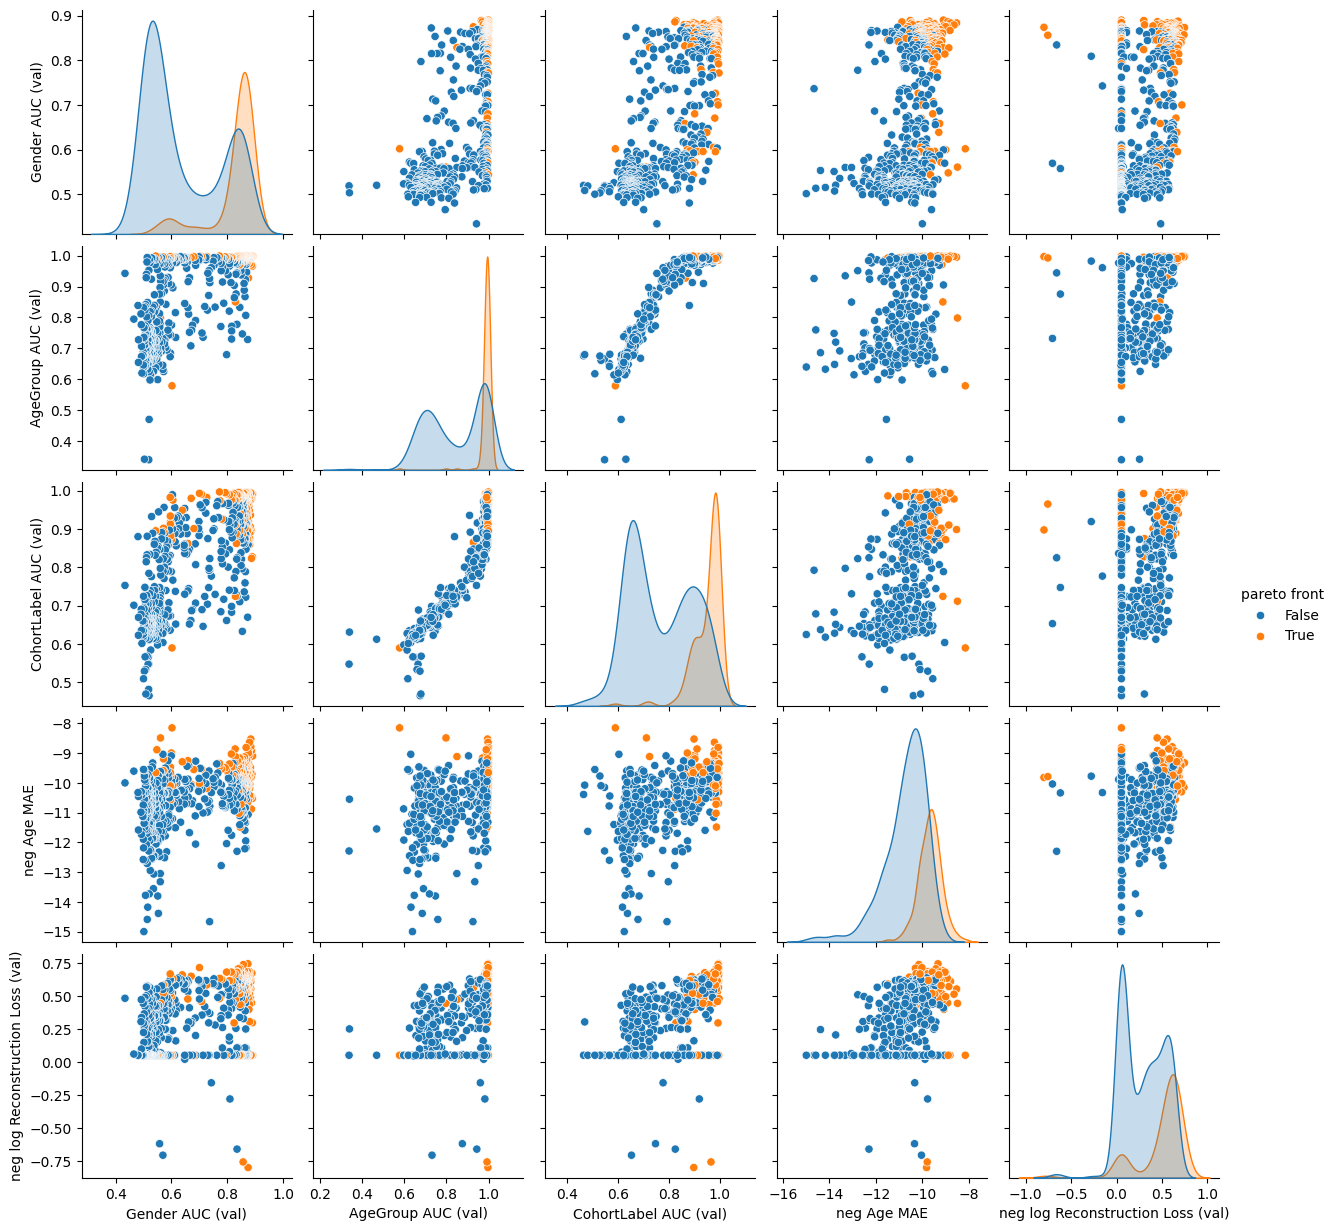

In [61]:
df_obj['pareto front'] = False
df_obj.loc[pareto_df.index, 'pareto front'] = True
sns.pairplot(df_obj, hue='pareto front')

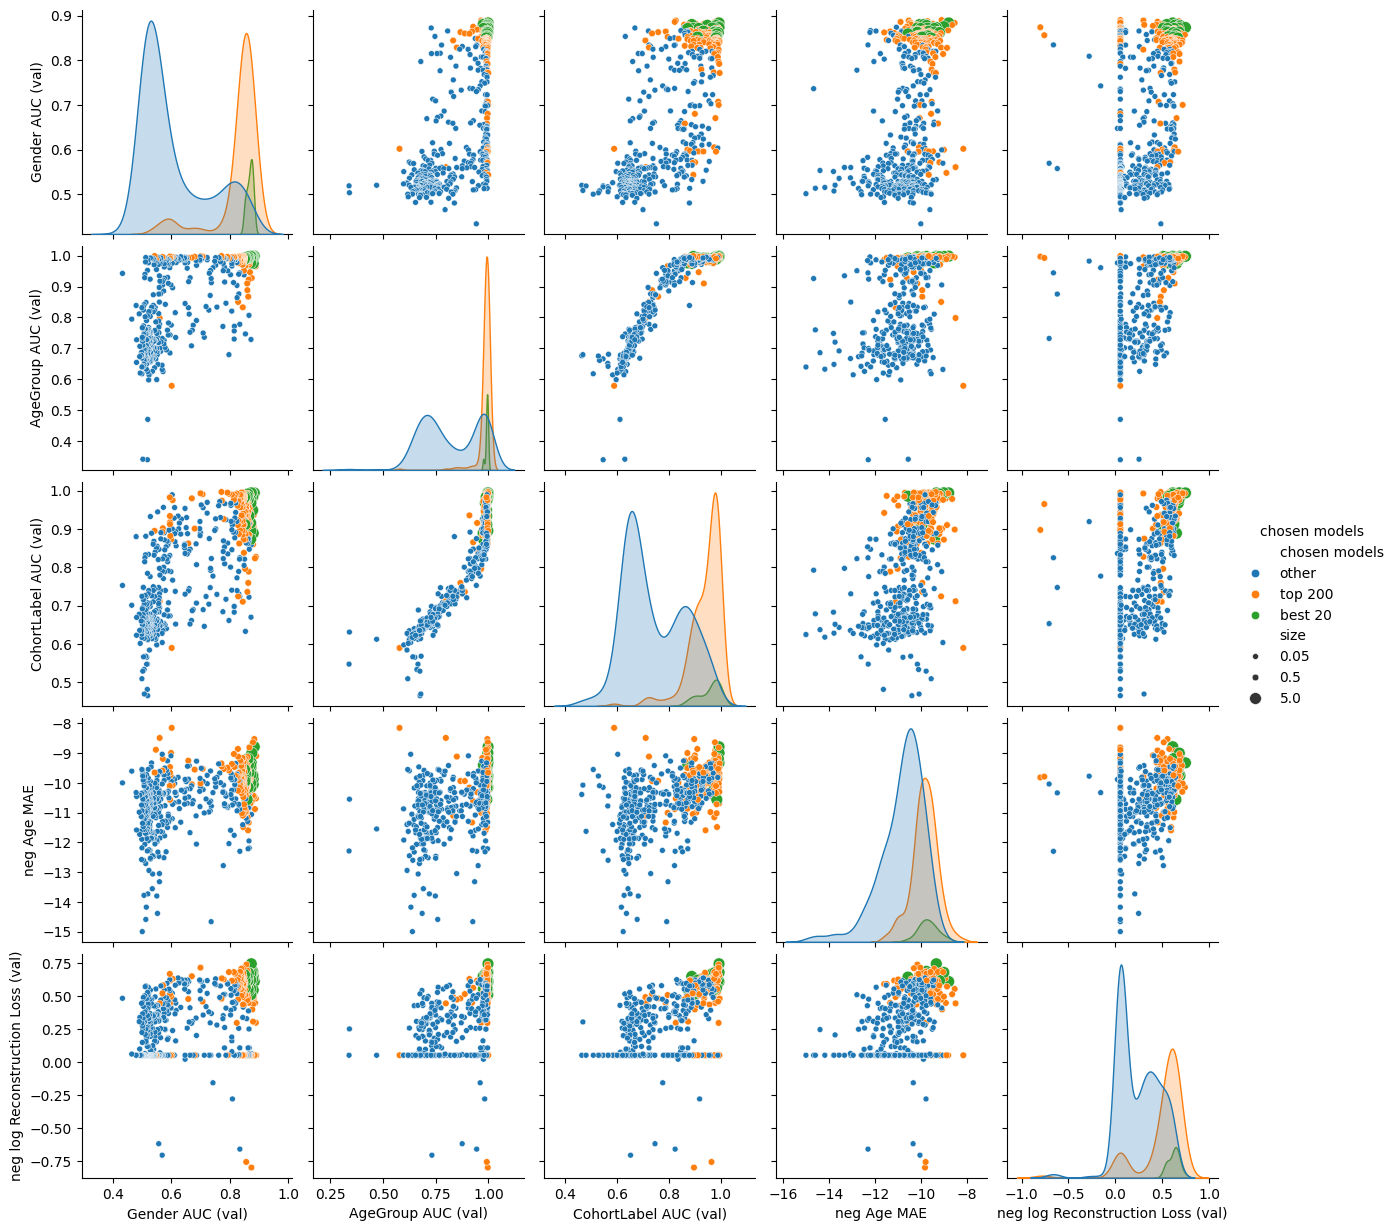

In [171]:
df_obj['chosen models'] = 'other'
df_obj.loc[vae_models['Has Tag april18_top200'], 'chosen models'] = 'top 200'
df_obj.loc[vae_models['Has Tag april18_best20'], 'chosen models'] = 'best 20'
df_obj['size'] = 0.05
df_obj.loc[vae_models['Has Tag april18_top200'], 'size'] = 0.5
df_obj.loc[vae_models['Has Tag april18_best20'], 'size'] = 5
not_size_cols = [col for col in df_obj.columns if col != 'size']
sns.pairplot(df_obj[not_size_cols], hue='chosen models',hue_order=['other','top 200','best 20'],plot_kws={'size':df_obj['size']})

In [166]:
df_obj

,Gender AUC (val),AgeGroup AUC (val),CohortLabel AUC (val),neg Age MAE,neg log Reconstruction Loss (val),chosen models,size
Id,,,,,,,
RCC-3013,0.890305,0.998471,0.990883,-9.093743,0.053260,top 200,2
RCC-2559,0.889301,0.965923,0.827350,-10.521715,0.300080,top 200,2
RCC-2987,0.887873,0.995976,0.989760,-9.704203,0.676420,top 200,2
RCC-2507,0.886695,0.995847,0.979680,-8.908306,0.450439,top 200,2
RCC-2549,0.886217,0.970000,0.823431,-10.877678,0.053255,top 200,2
...,...,...,...,...,...,...,...
RCC-2923,0.481922,0.727723,0.669301,-10.453390,0.053258,other,1
RCC-2539,0.481613,0.654470,0.622611,-11.581621,0.053258,other,1
RCC-3004,0.480185,0.838830,0.880076,-10.323528,0.053267,other,1


In [90]:
NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


## Tag best models from list

166


## Choose April20 Top 200

In [48]:
chosen_models = vae_models[vae_models['Has Tag april17_best90'] | vae_models['Has Tag april17_pareto']].index.to_list()

other_chosen_models = vae_models[(vae_models['Reconstruction Loss (val)'] < 0.65) & (vae_models['Gender AUC (val)'] >0.825) & (vae_models['Age MAE (val)'] < 12)].index.to_list()

print(len(other_chosen_models))

chosen_models= list(set(chosen_models + other_chosen_models))
print(len(chosen_models))

151
201


In [25]:
NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


In [51]:
for run_id in chosen_models:
    run = neptune.init_run(project='revivemed/RCC', api_token=NEPTUNE_API_TOKEN, with_id=run_id)
    run['sys/tags'].add('april18_top200')
    run.stop()

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2492
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2492/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2496
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2496/m

## Choose the Top 20 Models

In [57]:
best_df =  vae_models[vae_models['Has Tag april17_pareto']].copy()

best_df = best_df[(best_df['Latent dim'] > 40) & (best_df['# hidden layers'] < 4) & (best_df['# hidden layers'] > 1)].copy()

best_df = best_df[(best_df['Reconstruction Loss (val)'] < 0.6) & (best_df['Gender AUC (val)'] >0.85) & (best_df['Age MAE (val)'] < 11)].copy()

print(best_df.shape)

(21, 34)


In [55]:
top_20_models_df = vae_models[vae_models['Has Tag april17_best90'] & vae_models['Has Tag april17_pareto']].copy()

top_20_models = top_20_models_df[(top_20_models_df['Latent dim'] > 40) & (top_20_models_df['# hidden layers'] < 4) & (top_20_models_df['# hidden layers'] > 1)].index.to_list()

print(len(top_20_models))

21


In [56]:
for run_id in top_20_models:
    run = neptune.init_run(project='revivemed/RCC', api_token=NEPTUNE_API_TOKEN, with_id=run_id)
    run['sys/tags'].add('april18_best20')
    run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2390
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2390/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2964
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2964/m

## Chose Leila Top Models

In [21]:
vae_models

,Reconstruction Loss (val),StudyID AUC (val),CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),Age MAE (val),study name,"Both OS C-Index (finetune, val)","Both OS C-Index (randinit, val)","Both PFS C-Index (finetune, val)",...,model complexity,MSKCC AUC Diff (finetune-randinit),IMDC AUC Diff (finetune-randinit),Both OS C-Index Diff (finetune-randinit),Both PFS C-Index Diff (finetune-randinit),Has Tag april17_best90,Has Tag april17_pareto,Has Tag april15_leila,Has Tag april18_top200,Has Tag april18_best20
Id,,,,,,,,,,,,,,,,,,,,,
RCC-3013,0.948134,0.541620,0.990883,0.890305,0.998471,9.093743,Multi Obj Apr15,0.687362,0.520318,0.545353,...,400.0,0.367460,0.206177,0.167044,0.045353,False,True,False,True,False
RCC-2559,0.740759,0.777997,0.827350,0.889301,0.965923,10.521715,Multi Obj Apr12,NaN,NaN,0.560457,...,168.0,0.346869,0.113636,NaN,0.060457,False,True,False,True,False
RCC-2987,0.508434,0.504746,0.989760,0.887873,0.995976,9.704203,Multi Obj Apr15,0.674226,0.500000,0.553891,...,476.0,0.366071,0.413986,0.174226,0.053891,True,True,False,True,False
RCC-2507,0.637348,0.881439,0.979680,0.886695,0.995847,8.908306,Multi Obj Apr12,NaN,NaN,0.531973,...,58.0,0.131834,0.073271,NaN,0.031973,False,True,False,True,False
RCC-2549,0.948138,0.766172,0.823431,0.886217,0.970000,10.877678,Multi Obj Apr12,NaN,NaN,0.539786,...,122.0,0.365873,0.165812,NaN,0.039786,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-2731,0.565518,0.588918,0.446569,0.471697,0.502566,39.654396,Multi Obj Apr12,NaN,NaN,0.500000,...,315.0,0.009083,-0.191064,NaN,0.000000,False,False,False,False,False
RCC-2828,0.576448,0.604487,0.530451,0.468668,0.382603,38.956985,Multi Obj Apr12,0.500000,0.634237,0.500000,...,210.0,-0.111310,-0.317269,-0.134237,0.000000,False,False,False,False,False
RCC-2657,0.939616,0.702336,0.700982,0.465275,0.794672,9.603444,Multi Obj Apr12,NaN,NaN,0.556925,...,135.0,0.260847,0.083916,NaN,0.056925,False,False,False,False,False


In [22]:
best_df =  vae_models.copy()

# best_df = best_df[(best_df['Latent dim'] > 40) & (best_df['# hidden layers'] < 4) & (best_df['# hidden layers'] > 1)].copy()

best_df = best_df[(best_df['Reconstruction Loss (val)'] < 0.65) & (best_df['Gender AUC (val)'] >0.825) & (best_df['Age MAE (val)'] < 12)
                  & (best_df['AgeGroup AUC (val)'] > 0.9) & (best_df['CohortLabel AUC (val)'] > 0.9)].copy()

print(best_df.shape)

(123, 36)


In [23]:
best_df.index

Index(['RCC-2987', 'RCC-2507', 'RCC-2390', 'RCC-2370', 'RCC-2876', 'RCC-2848',
       'RCC-2425', 'RCC-2502', 'RCC-2956', 'RCC-2488',
       ...
       'RCC-2646', 'RCC-2187', 'RCC-2169', 'RCC-2273', 'RCC-2228', 'RCC-2338',
       'RCC-2246', 'RCC-2185', 'RCC-2344', 'RCC-3008'],
      dtype='object', name='Id', length=123)

In [26]:
for run_id in best_df.index:
    run = neptune.init_run(project='revivemed/RCC', api_token=NEPTUNE_API_TOKEN, with_id=run_id)
    run['sys/tags'].add('april18_leila')
    run.stop()

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2987
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2987/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2507
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2507/m